In [2]:
import glob
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fs=glob.glob('/Users/mgrecu/GPM/bZoneProfs/*Ocean*.nc')
print(sorted(fs))

['/Users/mgrecu/GPM/bZoneProfs/profs_Ocean_Nadir_20180101.nc', '/Users/mgrecu/GPM/bZoneProfs/profs_Ocean_Nadir_20180102.nc', '/Users/mgrecu/GPM/bZoneProfs/profs_Ocean_Nadir_20180103.nc', '/Users/mgrecu/GPM/bZoneProfs/profs_Ocean_Nadir_20180104.nc', '/Users/mgrecu/GPM/bZoneProfs/profs_Ocean_Nadir_20180105.nc', '/Users/mgrecu/GPM/bZoneProfs/profs_Ocean_Nadir_20180106.nc', '/Users/mgrecu/GPM/bZoneProfs/profs_Ocean_Nadir_20180107.nc', '/Users/mgrecu/GPM/bZoneProfs/profs_Ocean_Nadir_20180108.nc', '/Users/mgrecu/GPM/bZoneProfs/profs_Ocean_Nadir_20180109.nc', '/Users/mgrecu/GPM/bZoneProfs/profs_Ocean_Nadir_20180110.nc', '/Users/mgrecu/GPM/bZoneProfs/profs_Ocean_Nadir_20180111.nc', '/Users/mgrecu/GPM/bZoneProfs/profs_Ocean_Nadir_20180112.nc', '/Users/mgrecu/GPM/bZoneProfs/profs_Ocean_Nadir_20180113.nc', '/Users/mgrecu/GPM/bZoneProfs/profs_Ocean_Nadir_20180114.nc', '/Users/mgrecu/GPM/bZoneProfs/profs_Ocean_Nadir_20180115.nc', '/Users/mgrecu/GPM/bZoneProfs/profs_Ocean_Nadir_20180116.nc', '/Users

In [8]:
zmL=[[]for k in range(18)]
zmKaL=[[]for k in range(18)]
pRateL=[[]for k in range(18)]
pRateCMBL=[[]for k in range(18)]
#pRateCFAD=np.zeros((13,))
bcfL=[[]for k in range(18)]
lonlatL=[[]for k in range(18)]
ic=0
for f in sorted(fs)[:]:
    fh=nc.Dataset(f)
    pType=fh['pType'][:]
    zm=fh['zm'][:]
    pRate=fh['pRate'][:]
    pRateCMB=fh['pRateCMB'][:]
    bzd=fh['bzd'][:]
    bsfc=fh['bsfc'][:]
    bcFree=fh['bcFree'][:].data.astype(int)
    lon=fh['lon'][:]
    lat=fh['lat'][:]
    a=np.nonzero(bcFree>=168)
    ic+=len(a[0])
    #continue
    for i,zkum in enumerate(zm[:,:,0]):
        if bcFree[i]<168:
            continue
        ic+=1
        for k in range(-5,13):
            if (pType[i]==1) and abs(bzd[i]-160+2*k)<2:
                zkum[bcFree[i]-90:]=0
                zkam=zm[i,:,1]
                zkam[bcFree[i]-90:]=0
                pRate1=pRate[i,:]
                pRate1[bcFree[i]-90:]=0       
            #print(bzd[i],zkum[150-90:150-90+5])
                if bcFree[i]>=168:
                    zmL[k].append(zkum)
                    zmKaL[k].append(zkam)
                    pRateL[k].append(pRate1)
                    pRateCMBL[k].append(pRateCMB[i,:])
                    bcfL[k].append(bcFree[i])
                    lonlatL[k].append([lon[i],lat[i]])
        #print(ic)
    #print(fh)
    #break


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_29826/932832080.py:17: RuntimeWarning: invalid value encountered in cast
  bcFree=fh['bcFree'][:].data.astype(int)


89183 0
80671 1
76064 2
73819 3
73241 4
68665 5
60099 6
52230 7
50548 8
50770 9
66294 10
207324 11
179171 12


(30.0, -40.0)

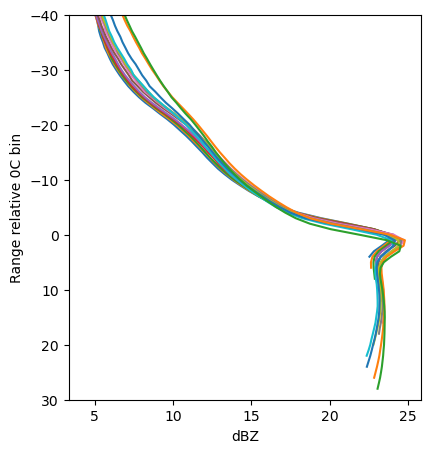

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(121)
for k in range(13):
    if len(zmL[k])<100:
        continue
    zmLk=np.array(zmL[k])
    zmLk[zmLk<0]=0
    plt.plot(zmLk.mean(axis=0)[:75],np.arange(75)+2*k-70)
    #plt.plot(zmLk.mean(axis=0)[(160-2*k-90):(160-2*k-90)+1],np.arange(70-2*k,70-2*k+1)+2*k-70,'*')
    print(len(zmLk),k)
    plt.xlabel('dBZ')
    plt.ylabel('Range relative 0C bin')
plt.ylim(30,-40)

In [10]:
import xarray as xr
zkumx=[]
zkamx=[]
pRatex=[]
pRateCMBx=[]
bcfx=[]
bzdx=xr.DataArray(160-np.arange(13)*2,dims=['nbins'])
d={}
for k in range(13):
    zkumx.append(xr.DataArray(np.array(zmL[k]),dims=['time%2.2i'%k,'range']))
    zkamx.append(xr.DataArray(np.array(zmKaL[k]),dims=['time%2.2i'%k,'range']))
    pRatex.append(xr.DataArray(np.array(pRateL[k]),dims=['time%2.2i'%k,'range']))
    pRateCMBx.append(xr.DataArray(np.array(pRateCMBL[k]),dims=['time%2.2i'%k,'range2']))
    bcfx.append(xr.DataArray(np.array(bcfL[k]),dims=['time%2.2i'%k]))
    d["zkum%2.2i"%k]=zkumx[k]
    d["zkam%2.2i"%k]=zkamx[k]
    d["pRate%2.2i"%k]=pRatex[k]
    d["pRateCMB%2.2i"%k]=pRateCMBx[k]
    d["bcf%2.2i"%k]=bcfx[k]
d["bzd"]=bzdx
ds=xr.Dataset(d)

comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in ds.data_vars}
ds.to_netcdf('stratiformProfilesOcean.nc',encoding=encoding)

In [104]:
import netCDF4 as nc
def readDBabse(nclass,fname,n5):
    with nc.Dataset(fname) as fh:
        zkum=fh.variables["zkum%2.2i"%nclass][:,:-n5]
        zkam=fh.variables["zkam%2.2i"%nclass][:,:-n5]
        pRate=fh.variables["pRate%2.2i"%nclass][:,:-n5]
    zm[zm<0]=0
    FL=168+2*nclass
    return zkum,zkam,pRate,FL

fnameO="stratiformProfilesOcean.nc"
fnameL="stratiformProfiles_2.nc"
ncl=12
zkumO,zkamO,pRateO,FL_O=readDBabse(ncl,fnameO,6)
zkumL,zkamL,pRateL,FL_L=readDBabse(ncl,fnameL,6)
zkumL[zkumL<0]=0
zkamL[zkamL<0]=0
zkumO[zkumO<0]=0
zkamO[zkamO<0]=0

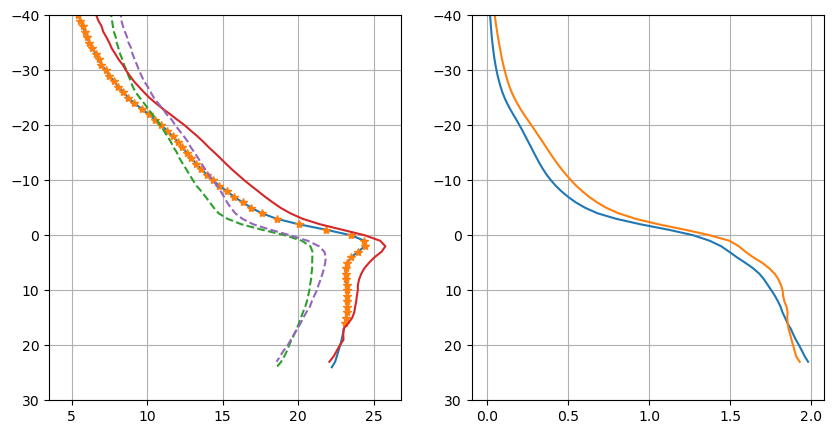

In [65]:
zmO.min()

plt.figure(figsize=(10,5))
plt.subplot(121)
nbin=zmO.shape[1]
plt.plot(zkumO.mean(axis=0)[0:79],np.arange(79)+2*ncl-70)
plt.plot(zkumO.mean(axis=0)[0:71],np.arange(71)+2*ncl-70,'*')
plt.plot(zkamO.mean(axis=0)[0:79],np.arange(79)+2*ncl-70,'--')
plt.plot(zkumL.mean(axis=0)[0:78],np.arange(78)+2*ncl-70)
plt.plot(zkamL.mean(axis=0)[0:78],np.arange(78)+2*ncl-70,'--')
plt.ylim(30,-40)
plt.grid()
plt.subplot(122)
nbin=zmO.shape[1]
plt.plot(pRateO.mean(axis=0)[0:78],np.arange(78)+2*ncl-70)
plt.plot(pRateL.mean(axis=0)[0:78],np.arange(78)+2*ncl-70)
plt.ylim(30,-40)
plt.grid()


In [116]:
slopeL=[]
for zkum1 in zkumO:
    resCoeff=np.polyfit(np.arange(63,67),zkum1[63:67],1)
    slopeL.append(resCoeff[0])


<BarContainer object of 7 artists>

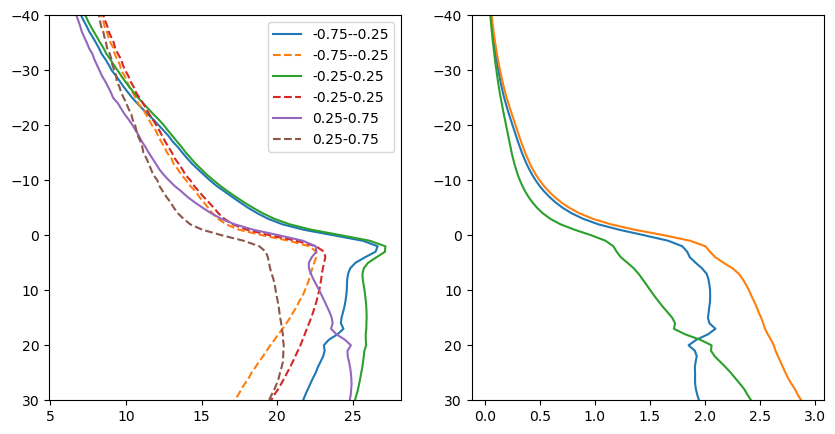

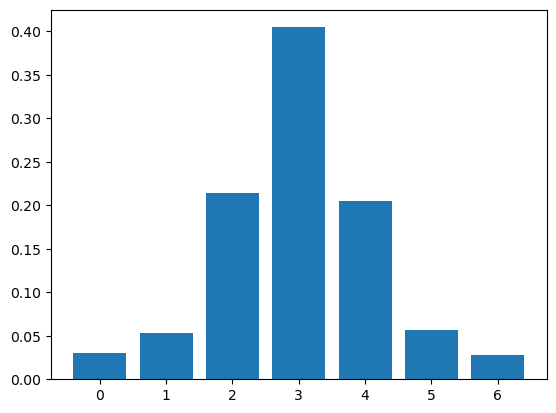

In [117]:
slopeL=np.array(slopeL)
bins=[-3,-1.25,-0.75,-0.25,0.25,0.75,1.25,3]
fractL=[]
plt.figure(figsize=(10,5))
ax1=plt.subplot(121)
ax2=plt.subplot(122)
for i in range(7):
    a=np.nonzero((slopeL>bins[i]) & (slopeL<bins[i+1]))
    print()
    fractL.append(len(a[0])/len(slopeL))
    if fractL[-1]*100>10:
        ax1.plot(zkumO[a[0],:].mean(axis=0)[0:79],np.arange(79)+2*ncl-70,label='%2.2f-%2.2f'%(bins[i],bins[i+1]))
        ax1.plot(zkamO[a[0],:].mean(axis=0)[0:79],np.arange(79)+2*ncl-70,'--',label='%2.2f-%2.2f'%(bins[i],bins[i+1]))
        ax2.plot(pRateO[a[0],:].mean(axis=0)[0:79],np.arange(79)+2*ncl-70,label='%2.2f-%2.2f'%(bins[i],bins[i+1]))  
        #plt.plot(zkumO[a[0],:].mean(axis=0)[0:63],np.arange(63)+2*ncl-70)
ax1.legend()
ax1.set_ylim(30,-40)
ax2.set_ylim(30,-40)

plt.figure()
plt.bar(np.arange(7),fractL)

In [124]:
slopeLL=[]
for i,zkum1 in enumerate(zkumL):
    resCoeff=np.polyfit(np.arange(67,71),pRateL[i,67:71],1)
    slopeLL.append(resCoeff[0])


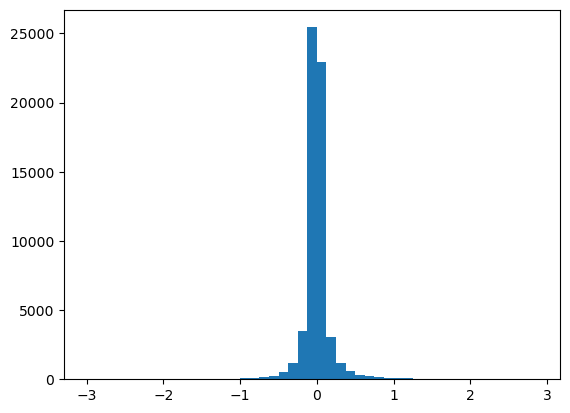

In [129]:
h1=plt.hist(slopeLL,bins=-3+np.arange(48)*0.125)

<BarContainer object of 7 artists>

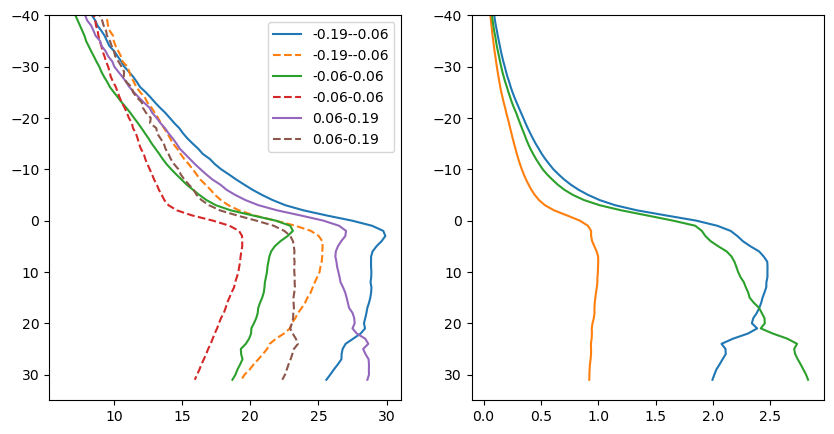

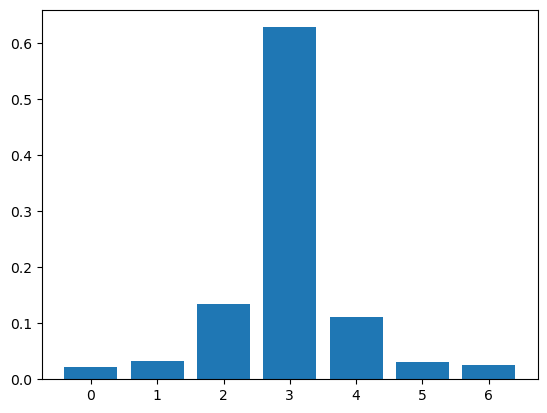

In [130]:

slopeLL=np.array(slopeLL)
bins=np.array([-3,-1.25,-0.75,-0.25,0.25,0.75,1.25,3])/4
fractLL=[]
plt.figure(figsize=(10,5))
ax1=plt.subplot(121)
ax2=plt.subplot(122)
for i in range(7):
    a=np.nonzero((slopeLL>bins[i]) & (slopeLL<bins[i+1]))
    fractLL.append(len(a[0])/len(slopeLL))
    if fractLL[-1]*100>10:
        ax1.plot(zkumL[a[0],:].mean(axis=0)[0:78],np.arange(78)+2*ncl-70,label='%2.2f-%2.2f'%(bins[i],bins[i+1]))
        ax1.plot(zkamL[a[0],:].mean(axis=0)[0:78],np.arange(78)+2*ncl-70,'--',label='%2.2f-%2.2f'%(bins[i],bins[i+1]))
        ax2.plot(pRateL[a[0],:].mean(axis=0)[0:78],np.arange(78)+2*ncl-70,label='%2.2f-%2.2f'%(bins[i],bins[i+1]))
        #plt.plot(zkumO[a[0],:].mean(axis=0)[0:63],np.arange(63)+2*ncl-70)
ax1.legend()
ax1.set_ylim(35,-40)
ax2.set_ylim(35,-40)

plt.figure()
plt.bar(np.arange(7),fractLL)

In [63]:
print(zkumO.shape)
import sklearn as sk
# define a tensorflow LSTM model with dimensions nbins x nchannel on input to extrapolate the profile


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks
from tensorflow.keras import models
from tensorflow.keras import utils
from tensorflow.keras import preprocessing
from tensorflow.keras import applications
from tensorflow.keras import backend as K




(50548, 80)
